# Figure 13: Identifying gaps in the proxy data
This notebook can be used to: 
- Generate the synthetic d13C signal used to produce the observations for Fig. 13
- Load the synthetic observations and inference results used to produce Fig. 13
- Calculate the temporal density of proxy observations
- 'Collect' new proxy observations from undersampled intervals

In [1]:
%load_ext autoreload
%autoreload 2

import arviz as az
import math
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
import seaborn as sns
import stratmc

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Avenir']
rcParams.update({
    "text.usetex": False
})

from scipy.ndimage import gaussian_filter as gaussian
from scipy.stats import gaussian_kde

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Synthetic d13C signal

In [2]:
age_vector = np.arange(200, 215, 0.25)

signals, prior = stratmc.synthetics.synthetic_signal_from_prior(age_vector, num_signals = 100, ls_mu = 2, var_sigma = 5, ls_lambda = 10, gp_mean_mu = 0, gp_mean_sigma = 2, seed = 0)

# use the first draw
d13c_signal = signals[:, 0]

Sampling: [f_rotated_, gp_ls_unshifted, gp_var, m]


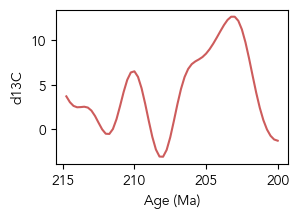

In [3]:
fig = plt.figure(figsize = (3, 2))
ax = fig.gca() 

ax.plot(age_vector, d13c_signal, color = 'indianred', label = 'Synthetic signal')

ax.invert_xaxis()
ax.set_xlabel('Age (Ma)');
ax.set_ylabel('d13C');

## Generate synthetic proxy observations
Build 3 synthetic stratigraphic sections. Manually set sample ages such that the excursion from ~212 to 208 Ma is undersampled. To load the observations, skip to [Load the synthetic data](#Load-the-synthetic-data).

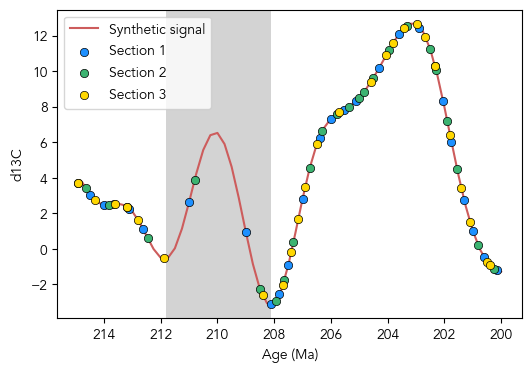

In [45]:
fig = plt.figure(figsize = (6, 4))
ax = fig.gca()

ax.plot(age_vector, d13c_signal, color = 'indianred', zorder = 0, label = 'Synthetic signal')

# highlight the excursion interval
ax.axvspan(211.8, 208.1,linestyle = 'none', color = 'lightgray', zorder = -1)

# section 1
ages_1 = [214.5, 214, 213.65, 213.1, 212.63, 211, 209, 208.1, 207.82, 207.5, 207, 206.4, 206, 205.55, 205.12, 204.3, 203.6, 202.88, 202.34, 202.05, 201.75, 201.3, 201, 200.6, 200.15] 
heights_1 = (np.arange(len(ages_1)) * 1) + 0.1
d13c_1 = np.interp(ages_1, age_vector, d13c_signal)
ax.scatter(ages_1, d13c_1, color = 'dodgerblue',  edgecolor = 'k', lw = 0.5, label = 'Section 1')

# section 2
ages_2 = [214.9, 214.65, 213.82, 213.18, 212.45, 210.8, 208.5, 207.95, 207.65, 207.32, 206.75, 206.3, 205.8, 205.37, 205, 204.85, 204.5, 203.95, 203.32, 202.5, 202.3, 201.9, 201.55, 200.8, 200.25] 
heights_2 = (np.arange(len(ages_2)) * 1) + 0.05
d13c_2 = np.interp(ages_2, age_vector, d13c_signal)
ax.scatter(ages_2, d13c_2, color = 'mediumseagreen',  edgecolor = 'k', lw = 0.5, label = 'Section 2')
 
ages_3 = [214.9, 214.33, 213.6, 213.2, 212.8, 211.9, 208.4, 207.7, 207.4, 207.15, 206.9, 206.5, 205.7, 204.6, 204.05, 203.8, 203.42, 202.98, 202.67, 202.34, 201.8, 201.4, 201.09, 200.5, 200.39] 
heights_3 = (np.arange(len(ages_3)) * 1) + 0.15
d13c_3 = np.interp(ages_3, age_vector, d13c_signal)
ax.scatter(ages_3, d13c_3, color = 'gold', edgecolor = 'k', lw = 0.5, label = 'Section 3')

ax.invert_xaxis() 
ax.set_xlabel('Age (Ma)');
ax.set_ylabel('d13C');

ax.legend()

In [46]:
# Create DataFrames with the proxy observations and age constraints 

section_1_dict = {'section': ['1'] * len(ages_1), 
                  'height': heights_1, 
                  'age': ages_1, 
                  'd13c': d13c_1, 
                  'Exclude?': [False] * len(ages_1)
}

section_1_age_constraints = np.array([215, 208, 200]) 
section_1_age_constraint_std = np.array([1, 0.8, 1.2])
section_1_age_heights = np.array([0, 7.5, 24.3])

section_1_ages_dict = {'section': ['1'] * len(section_1_age_constraints), 
                  'height': section_1_age_heights, 
                  'age': section_1_age_constraints,
                    'age_std': section_1_age_constraint_std,
                       'shared?': [False] * len(section_1_age_constraints), 
                       'name': [np.nan] * len(section_1_age_constraints), 
                    'intermediate detrital?': [False] * len(section_1_age_constraints), 
                       'intermediate intrusive?': [False] * len(section_1_age_constraints),
                  'Exclude?': [False] * len(section_1_age_constraints), 
                    'distribution_type': ['Normal'] * len(section_1_age_constraints)
}

sample_df_1 = pd.DataFrame.from_dict(section_1_dict)
ages_df = pd.DataFrame.from_dict(section_1_ages_dict)


section_2_dict = {'section': ['2'] * len(ages_2), 
                  'height': heights_2, 
                  'age': ages_2, 
                  'd13c': d13c_2, 
                  'Exclude?': [False] * len(ages_2)
}

section_2_age_constraints = np.array([215, 212, 200]) 
section_2_age_constraint_std = np.array([1.1, 0.4, 0.9])
section_2_age_heights = np.array([0, 4.2, 24.1])

section_2_ages_dict = {'section': ['2'] * len(section_2_age_constraints), 
                  'height': section_2_age_heights, 
                  'age': section_2_age_constraints,
                    'age_std': section_2_age_constraint_std,
                       'shared?': [False] * len(section_2_age_constraints), 
                       'name': [np.nan] * len(section_2_age_constraints), 
                    'intermediate detrital?': [False] * len(section_2_age_constraints), 
                       'intermediate intrusive?': [False] * len(section_2_age_constraints),
                  'Exclude?': [False] * len(section_2_age_constraints), 
                    'distribution_type': ['Normal'] * len(section_2_age_constraints)
}

sample_df_1 = pd.concat([sample_df_1, pd.DataFrame.from_dict(section_2_dict)], ignore_index = True)
ages_df = pd.concat([ages_df, pd.DataFrame.from_dict(section_2_ages_dict)], ignore_index = True)

section_3_dict = {'section': ['3'] * len(ages_3), 
                  'height': heights_3, 
                  'age': ages_3, 
                  'd13c': d13c_3, 
                  'Exclude?': [False] * len(ages_3)
}

section_3_age_constraints = np.array([215, 208, 200]) 
section_3_age_constraint_std = np.array([1.5, 1, 0.6])
section_3_age_heights = np.array([0, 6.5, 24.25])

section_3_ages_dict = {'section': ['3'] * len(section_3_age_constraints), 
                  'height': section_3_age_heights, 
                  'age': section_3_age_constraints,
                    'age_std': section_3_age_constraint_std,
                       'shared?': [False] * len(section_3_age_constraints), 
                       'name': [np.nan] * len(section_3_age_constraints), 
                    'intermediate detrital?': [False] * len(section_3_age_constraints), 
                       'intermediate intrusive?': [False] * len(section_3_age_constraints),
                  'Exclude?': [False] * len(section_3_age_constraints), 
                    'distribution_type': ['Normal'] * len(section_3_age_constraints)
}

sample_df_1 = pd.concat([sample_df_1, pd.DataFrame.from_dict(section_3_dict)], ignore_index = True)
ages_df = pd.concat([ages_df, pd.DataFrame.from_dict(section_3_ages_dict)], ignore_index = True)

sections = np.unique(sample_df_1['section'])

# stratmc.data.save_object(sample_df_1, 'data/Fig13_sample_df_original')
# stratmc.data.save_object(ages_df, 'data/Fig13_ages_df')

## Load the synthetic data
Load the proxy observations and age constraints generated in [Generate synthetic proxy observations](#Generate-synthetic-proxy-observations). 

In [4]:
sample_df_1 = stratmc.data.load_object('data/Fig13_sample_df_original')
ages_df = stratmc.data.load_object('data/Fig13_ages_df')

sections = np.unique(sample_df_1['section'])

## Plot the observations

### Proxy stratigraphy

Text(0, 0.5, 'Height (m)')

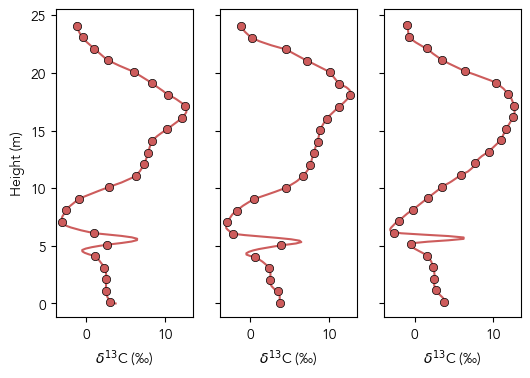

In [5]:
fs = 10 

fig, ax = plt.subplots(1, 3, figsize = (6, 4), sharex = True, sharey = True) 

for i, section in enumerate(sections): 
    section_ages_df = ages_df[(ages_df['section'] == section) & (~np.isnan(ages_df['age'])) & (~ages_df['intermediate detrital?'])]
    section_df = sample_df_1[sample_df_1['section'] == section]

    sec_sample_ages = sample_df_1[sample_df_1['section'] == section]['age'].values
    sec_sample_heights =sample_df_1[sample_df_1['section'] == section]['height'].values

    sec_radio_ages = section_ages_df['age'].values
    sec_ages_comb = np.concatenate([sec_radio_ages, section_df['age']])

    heights_comb = np.concatenate([section_ages_df['height'], section_df['height']])

    heights_comb_sort_idx = np.argsort(heights_comb)

    sec_ages_comb = sec_ages_comb[heights_comb_sort_idx]
    heights_comb = heights_comb[heights_comb_sort_idx]

    new_heights = np.linspace(np.min(heights_comb), np.max(heights_comb), 200)
    sec_age_interp = np.interp(new_heights, heights_comb, sec_ages_comb)

    d13c_section_interp = np.interp(sec_age_interp, age_vector, d13c_signal)

    ax[i].plot(d13c_section_interp, new_heights, c =  'indianred', zorder = 0)

    ax[i].scatter(section_df['d13c'],
                 section_df['height'], 
                  color = 'indianred', 
                  lw = 0.5,
                  edgecolor = 'k', 
                 clip_on = False, 
                 zorder = 3)
    
    ax[i].set_xlabel('$\delta^{13}$C (‰)', fontsize = fs) 


ax[0].set_ylabel('Height (m)', fontsize = fs) 

### Section age models
Note the condensed interval from 212 to 208 Ma in each section, which results in undersampling when samples are collected with a regular stratigraphic spacing.

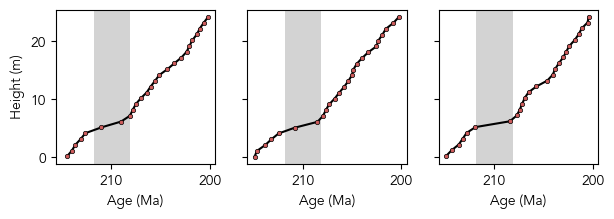

In [7]:
fs = 10 

fig, ax = plt.subplots(1, 3, figsize = (7, 2), sharex = True, sharey = True) 

for i, section in enumerate(sections): 
    section_ages_df = ages_df[(ages_df['section'] == section) & (~np.isnan(ages_df['age'])) & (~ages_df['intermediate detrital?'])]
    section_df = sample_df_1[sample_df_1['section'] == section]


    ax[i].plot(section_df['age'], section_df['height'], c =  'black', zorder = 0)

    ax[i].scatter(section_df['age'],
                 section_df['height'], 
                 s = 10, 
                  color = 'indianred', 
                  lw = 0.5,
                  edgecolor = 'k', 
                 clip_on = False, 
                 zorder = 3)
    
    ax[i].set_xlabel('Age (Ma)', fontsize = fs) 
    
    ax[i].axvspan(211.8, 208.1, color = 'lightgray', linestyle = 'none', zorder = -1)


ax[0].set_ylabel('Height (m)', fontsize = fs) 
ax[0].invert_xaxis()

## Build the inference model and sample the posterior
To load the results for the inference used to produce Fig. 13, skip to [Load the inference results](#Load-the-inference-results). 

In [8]:
model, gp = stratmc.model.build_model(sample_df_1, 
                            ages_df, 
                            proxies = ['d13c'],
                            ls_dist = 'Wald',
                            ls_min = 1, 
                            ls_mu = 2, 
                            ls_lambda = 10, 
                            var_sigma = 5, 
                            noise_type = 'section',
                            offset_type = 'section')

In [ ]:
predict_ages = age_vector[:, None]

chains = 100
draws = 1000
tune = 1000
target_accept = 0.9


extension = 'Fig13_proxy_data_gaps_original_data'

full_trace = stratmc.inference.get_trace(model, 
                                           gp, 
                                           predict_ages,
                                           sample_df_1, 
                                           ages_df,
                                           proxies = ['d13c'], 
                                           name = extension, 
                                           chains = 100, 
                                           target_accept = 0.9
                                          ) 
    


## Load the inference results

In [9]:
full_trace = stratmc.data.load_trace('traces/Fig13_proxy_data_gaps_original_data')

/Users/staceyedmonsond/opt/anaconda3/envs/bayestrat-dev-m1-pymc516-accelerate/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: X_new group is not defined in the InferenceData scheme
  warnings.warn(


## Plot the inference results with `stratmc.plotting`

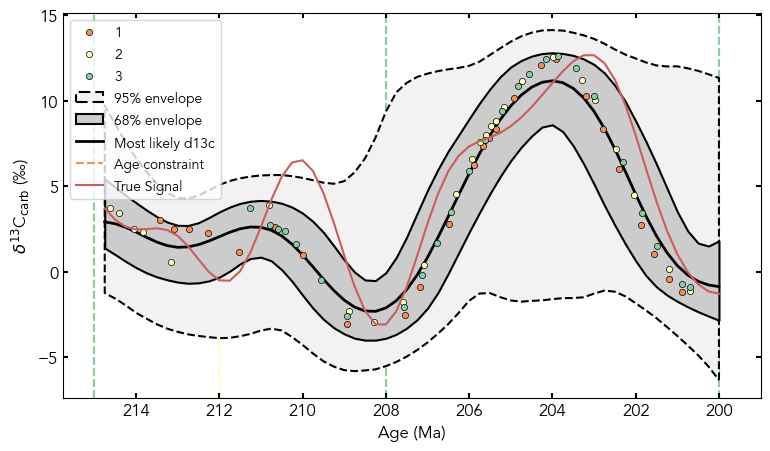

In [11]:
fig = stratmc.plotting.proxy_inference(sample_df_1, ages_df, full_trace, sections=sections, 
                  orientation = 'horizontal', plot_constraints = True, plot_data = True,
                  section_legend = True, proxy = 'd13c')

ax = fig.gca()
ax.plot(age_vector, d13c_signal, color = 'indianred', label = 'True Signal', zorder = 10)

plt.legend()

plt.show()

## Identify gaps in the proxy data

### Plot temporal data density with `stratmc.plotting.proxy_data_density``

Counting data in time bins


  0%|          | 0/59 [00:00<?, ?it/s]

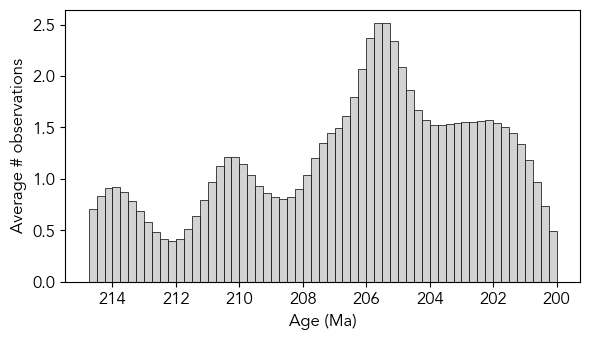

In [12]:
fig = stratmc.plotting.proxy_data_density(full_trace)

## Grab sample counts in each time bin, and find intervals with a below-average number of observations

In [13]:
sample_count_1, grid_centers_1, grid_widths_1, n_1 = stratmc.inference.count_samples(full_trace)

Counting data in time bins


  0%|          | 0/59 [00:00<?, ?it/s]

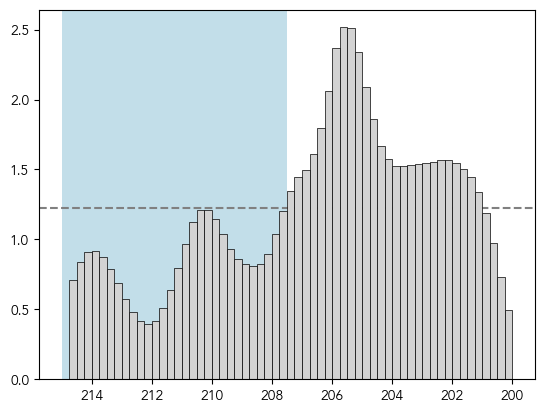

In [14]:
# temporal density of observations
fig = plt.figure()
ax = fig.gca()

# bar plot of average sample counts
ax.bar(grid_centers_1, height = sample_count_1/n_1, width = grid_widths_1, color = 'lightgray', edgecolor = 'k', lw = 0.5, zorder = 2)

# plot the mean as a dashed line
ax.axhline(np.mean(sample_count_1/n_1), color = 'gray', linestyle = 'dashed', zorder = 1)

ax.invert_xaxis()
ax.axvspan(215, 207.5, facecolor = '#87BED5', edgecolor = 'none', zorder = 0, alpha = 0.5)

### Map undersampled interval (215 to 207.5 Ma) back to height in each stratigraphic section 
Use `stratmc.inference.age_range_to_height` to determine where additional samples should be collected. We plot the results manually here (because we need to access the DataFrame containing the heights of the target intervals), but note that `stratmc.plotting.section_age_range` also can be used to visualize the target interval for each section. 

Mapping age models to sections


  0%|          | 0/3 [00:00<?, ?it/s]

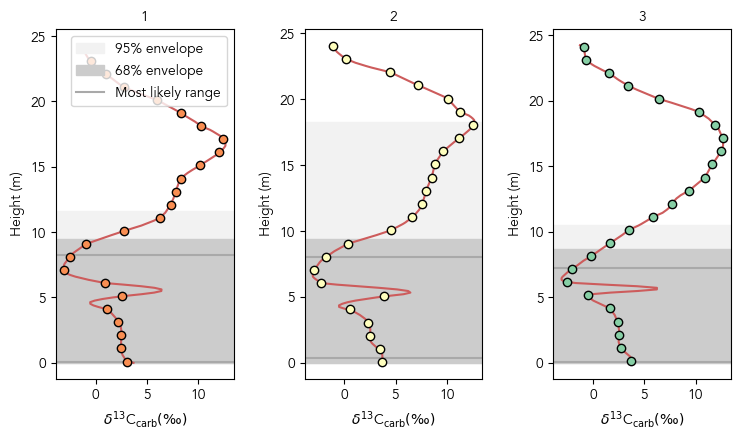

In [15]:
lower_age = 207.5
upper_age = 215

tracer = 'd13c'
legend = True

stats_df = stratmc.inference.age_range_to_height(full_trace, sample_df_1, ages_df, lower_age, upper_age)
    
sections = stats_df.index.tolist()

cs = {}
pal = sns.color_palette('Spectral', n_colors=len(sections))

cols = 4
N = len(sections)
rows = int(math.ceil(N/cols))

gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize = (10, 4.5*rows))

for n in range(N):
    section = sections[n]
    cs[section] = pal[n]
    ax = fig.add_subplot(gs[n])

    section_df = sample_df_1[sample_df_1['section']==section]

    ax.scatter(section_df[tracer], section_df['height'], color = cs[section], edgecolor = 'k', zorder = 4)
    
    section_ages_df = ages_df[(ages_df['section'] == section) & (~np.isnan(ages_df['age'])) & (~ages_df['intermediate detrital?'])]
    section_df = sample_df_1[sample_df_1['section'] == section]

    sec_sample_ages = sample_df_1[sample_df_1['section'] == section]['age'].values
    sec_sample_heights =sample_df_1[sample_df_1['section'] == section]['height'].values

    sec_radio_ages = section_ages_df['age'].values
    sec_ages_comb = np.concatenate([sec_radio_ages, section_df['age']])

    heights_comb = np.concatenate([section_ages_df['height'], section_df['height']])

    heights_comb_sort_idx = np.argsort(heights_comb)

    sec_ages_comb = sec_ages_comb[heights_comb_sort_idx]
    heights_comb = heights_comb[heights_comb_sort_idx]

    new_heights = np.linspace(np.min(heights_comb), np.max(heights_comb), 200)
    sec_age_interp = np.interp(new_heights, heights_comb, sec_ages_comb)

    d13c_section_interp = np.interp(sec_age_interp, age_vector, d13c_signal)

    ax.plot(d13c_section_interp, new_heights, c =  'indianred', zorder = 3)

    ax.axhspan(stats_df.loc[section]['base_2.5'], stats_df.loc[section]['top_97.5'], zorder = 0, color = (0.95, 0.95, 0.95), label='95% envelope')
    ax.axhspan(stats_df.loc[section]['base_16'], stats_df.loc[section]['top_84'], zorder = 1, color = (0.8, 0.8, 0.8), label='68% envelope')
    ax.axhline(stats_df.loc[section]['base_mle'], color = 'darkgray', linestyle = 'solid', zorder = 2)
    ax.axhline(stats_df.loc[section]['top_mle'], color = 'darkgray', linestyle = 'solid', zorder = 2, label = 'Most likely range')

    ax.set_ylabel('Height (m)', fontsize = fs)
    if tracer == 'd13c':
        ax.set_xlabel('$\delta^{13}$C$_{\mathrm{carb}} (‰)$', fontsize = fs)
    else:
        ax.set_xlabel(tracer, fontsize = fs)

    ax.set_title(section, fontsize = fs)
    ax.tick_params(labelsize=fs)
    ax.locator_params(axis='x', nbins=5)

    if legend:
        if n == 0:
            ax.legend()

fig.tight_layout()

plt.subplots_adjust(wspace=0.4)

## Collect additional samples from the undersampled interval
``stats_df`` contains the estimated stratigraphic boundaries of the target interval. We're going to collect additional samples from the 68% posterior envelope. 

To load the DataFrame with the upsampled proxy observations, skip to [Load the upsampled proxy observations](#Load-the-upsampled-proxy-observations). 

In [16]:
stats_df

,base_mle,base_2.5,base_16,base_50,base_84,base_97.5,top_mle,top_2.5,top_16,top_50,top_84,top_97.5
section,,,,,,,,,,,,
1,0.071691,0.0,0.0,0.017217,0.341589,3.286464,8.280769,7.197958,7.519691,8.129026,9.504854,11.634641
2,0.374535,0.0,0.0,0.043365,3.097248,4.073024,8.064255,4.741088,6.995755,8.170120,9.372658,18.236364
3,0.031213,0.0,0.0,0.000000,0.098963,1.785145,7.213726,6.163628,6.527117,7.211830,8.698928,10.510327


In [17]:
for section in sections: 
    print('Base of interval in section ' + str(section) + ' ' + str(stats_df.loc[section]['base_16']))
    print('Top of interval in section ' + str(section) + ' ' + str(stats_df.loc[section]['top_84']))

Base of interval in section 1 0.0
Top of interval in section 1 9.504854384407086
Base of interval in section 2 0.0
Top of interval in section 2 9.372658275550963
Base of interval in section 3 0.0
Top of interval in section 3 8.69892757586822


In [18]:
sample_df_2 = sample_df_1.copy()

new_heights = {}
new_d13c = {} 
new_ages = {} 
for section in sections: 
    resample_base = stats_df.loc[section]['base_16']#['base_2.5']
    resample_top = stats_df.loc[section]['top_84']#['top_97.5']
    section_df = sample_df_1[sample_df_1['section']==section]
    resample_idx = np.where((section_df['height'] >= resample_base) & (section_df['height'] <= resample_top))[0]
        
    # collect 2 new samples in between every existing sample
    for i in np.arange(len(resample_idx) - 1):
        idx = resample_idx[i]
        next_idx = resample_idx[i + 1]
        if i == 0: 
            new_heights[section] =  np.linspace(section_df['height'].values[idx], section_df['height'].values[next_idx], 4)[1:-1]

        else:
            new_heights[section] = np.append(new_heights[section],  np.linspace(section_df['height'].values[idx], section_df['height'].values[next_idx], 4)[1:-1])

    
    new_ages[section] = np.interp(new_heights[section], section_df['height'].values, section_df['age'].values)
    new_d13c[section] = np.interp(new_ages[section], age_vector, d13c_signal)
    
    section_dict = {'section': [section] * len(new_ages[section]), 
                  'height': new_heights[section], 
                  'age': new_ages[section], 
                  'd13c': new_d13c[section], 
                  'Exclude?': [False] * len(new_ages[section])
    }

    sample_df_2 = pd.concat([sample_df_2, pd.DataFrame.from_dict(section_dict)], ignore_index = True)

                      
sample_df_2, ages_df = stratmc.data.clean_data(sample_df_2, ages_df, ['d13c'], sections)

# stratmc.data.save_object(sample_df_2, 'data/Fig13_sample_df_upsampled')

## Load the upsampled proxy observations
Load the data generated in [Collect additional samples from the undersampled interval](#Collect-additional-samples-from-the-undersampled-interval). 

In [19]:
sample_df_2 = stratmc.data.load_object('data/Fig13_sample_df_upsampled')

## Plot the upsampled proxy observations

Text(0, 0.5, 'Height (m)')

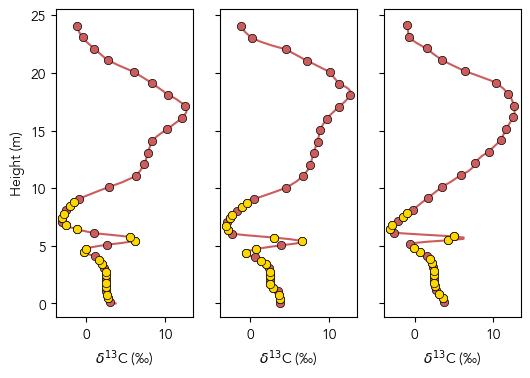

In [20]:
fig, ax = plt.subplots(1, len(sections), figsize = (6, 4), sharey = True)

for i, section in enumerate(sections): 
    ax[i].scatter(sample_df_2[sample_df_2['section'] == section]['d13c'], 
                  sample_df_2[sample_df_2['section'] == section]['height'], 
                  color = 'indianred', 
                  edgecolor = 'k',
                  lw = 0.5)
    
    ax[i].scatter(new_d13c[section], 
                  new_heights[section], 
                  color = 'gold', 
                  edgecolor = 'k',
                  lw = 0.5)
    
    section_ages_df = ages_df[(ages_df['section'] == section) & (~np.isnan(ages_df['age'])) & (~ages_df['intermediate detrital?'])]
    section_df = sample_df_2[sample_df_2['section'] == section]

    sec_sample_ages = sample_df_2[sample_df_2['section'] == section]['age'].values
    sec_sample_heights =sample_df_2[sample_df_2['section'] == section]['height'].values

    sec_radio_ages = section_ages_df['age'].values
    sec_ages_comb = np.concatenate([sec_radio_ages, section_df['age']])

    heights_comb = np.concatenate([section_ages_df['height'], section_df['height']])

    heights_comb_sort_idx = np.argsort(heights_comb)

    sec_ages_comb = sec_ages_comb[heights_comb_sort_idx]
    heights_comb = heights_comb[heights_comb_sort_idx]

    new_heights_interp = np.linspace(np.min(heights_comb), np.max(heights_comb), 200)
    sec_age_interp = np.interp(new_heights_interp, heights_comb, sec_ages_comb)

    d13c_section_interp = np.interp(sec_age_interp, age_vector, d13c_signal)

    ax[i].plot(d13c_section_interp, new_heights_interp, c =  'indianred', zorder = 0)
    
    ax[i].set_xlabel('$\delta^{13}$C (‰)', fontsize = fs) 

    
ax[0].set_ylabel('Height (m)')
    

## Generate Fig. 13

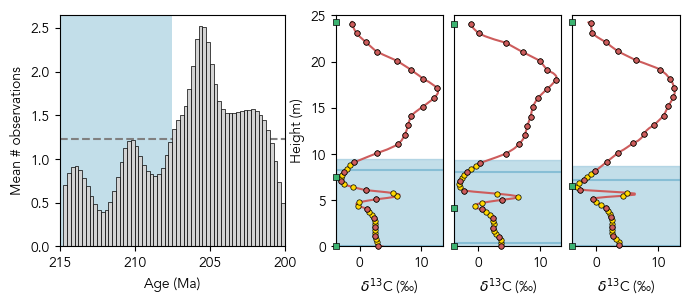

In [21]:
mosaic = """
    aaaaaa.111222333
    aaaaaa.111222333
    aaaaaa.111222333
    """

fs = 10
fig, ax = plt.subplot_mosaic(mosaic,  figsize = (8, 3), sharex = False, sharey = False, constrained_layout = False)

[ax[i].sharex(ax['1']) for i in ['2', '3']]
[ax[i].sharey(ax['1']) for i in ['2', '3']]

for i in ['2', '3']:
    [t.set_color('none') for t in ax[i].yaxis.get_ticklabels()]
    ax[i].tick_params(axis = 'y', color = 'none')
 
# stratigraphic observations
for section in sections: 
    ax[section].scatter(sample_df_2[sample_df_2['section'] == section]['d13c'], 
                  sample_df_2[sample_df_2['section'] == section]['height'], 
                  color = 'gold', 
                  edgecolor = 'k',
                        s = 15, 
                  lw = 0.5, 
                       zorder = 4, 
                       clip_on = False)
    
    ax[section].scatter(sample_df_1[sample_df_1['section'] == section]['d13c'], 
                  sample_df_1[sample_df_1['section'] == section]['height'], 
                  color = 'indianred', 
                  edgecolor = 'k',
                  lw = 0.5, 
                        s = 15,
                       zorder = 5, 
                       clip_on = False)
    
    section_ages_df = ages_df[(ages_df['section'] == section) & (~np.isnan(ages_df['age'])) & (~ages_df['intermediate detrital?'])]
    section_df = sample_df_2[sample_df_2['section'] == section]

    sec_sample_ages = sample_df_2[sample_df_2['section'] == section]['age'].values
    sec_sample_heights =sample_df_2[sample_df_2['section'] == section]['height'].values

    sec_radio_ages = section_ages_df['age'].values
    sec_ages_comb = np.concatenate([sec_radio_ages, section_df['age']])

    heights_comb = np.concatenate([section_ages_df['height'], section_df['height']])

    heights_comb_sort_idx = np.argsort(heights_comb)

    sec_ages_comb = sec_ages_comb[heights_comb_sort_idx]
    heights_comb = heights_comb[heights_comb_sort_idx]

    new_heights_interp = np.linspace(np.min(heights_comb), np.max(heights_comb), 200)
    sec_age_interp = np.interp(new_heights_interp, heights_comb, sec_ages_comb)

    d13c_section_interp = np.interp(sec_age_interp, age_vector, d13c_signal)

    ax[section].plot(d13c_section_interp, new_heights_interp, c =  'indianred', zorder = 3)

    ax[section].axhspan(stats_df.loc[section]['base_16'], stats_df.loc[section]['top_84'], zorder = 1, color = '#87BED5', alpha = 0.5, label='68% envelope')
    ax[section].axhline(stats_df.loc[section]['base_mle'], color = '#87BED5', linestyle = 'solid', zorder = 2)
    ax[section].axhline(stats_df.loc[section]['top_mle'], color = '#87BED5', linestyle = 'solid', zorder = 2, label = 'Most likely range')
    ax[section].set_xlabel('$\delta^{13}$C (‰)', fontsize = fs)
    
    
ax['1'].set_ylim([0, 25])
ax['1'].set_ylabel('Height (m)', fontsize = fs) 

xl = ax['1'].get_xlim()
for section in sections: 
    section_ages_df = ages_df[ages_df['section'] == section]
    
    for k in np.arange(section_ages_df.shape[0]):
        ax[section].scatter(xl[0], section_ages_df.iloc[k]['height'], color = 'mediumseagreen', edgecolor = 'k', marker = 's', s = 25,  lw = 0.5, zorder = 10, clip_on = False)


ax['1'].set_xlim(xl)

# temporal density of observations
ax['a'].bar(grid_centers_1, height = sample_count_1/n_1, width = grid_widths_1, color = 'lightgray', edgecolor = 'k', lw = 0.5, zorder = 2)
ax['a'].axhline(np.mean(sample_count_1/n_1), color = 'gray', linestyle = 'dashed', zorder = 1)

ax['a'].invert_xaxis()
ax['a'].axvspan(215, 207.5, facecolor = '#87BED5', edgecolor = 'none', zorder = 0, alpha = 0.5)
ax['a'].set_ylabel('Mean # observations', fontsize = fs)
ax['a'].set_xlabel('Age (Ma)', fontsize = fs)
ax['a'].set_xlim([215, 200])


fig.subplots_adjust(wspace = 0.4) # hspace = 3.5, 

for key in list(ax.keys()): 
    ax[key].tick_params(labelsize = fs) 

    